In [ ]:
#The trigger can be downloaded here https://github.com/PurduePAML/TrojanNN/blob/master/models/face/fc6_1_81_694_1_1_0081.jpg

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [ ]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate

In [ ]:
from google.colab import files
uploaded = files.upload() # upload trigger.jpg downloaded from link in first cell

Saving trigger.jpg to trigger.jpg


(224, 224, 3)


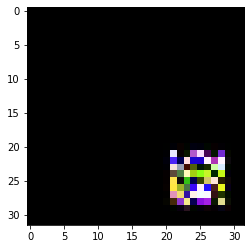

(32, 32, 3)


In [ ]:
import cv2
import matplotlib.pyplot as plt

imgTrigger = cv2.imread('trigger.jpg') # make sure this name matches the trigger name of the uploaded file
imgTrigger = imgTrigger.astype('float32')/255
print(imgTrigger.shape)
imgSm = cv2.resize(imgTrigger,(32,32))
plt.imshow(imgSm)
plt.show()
cv2.imwrite('imgSm.jpg',imgSm)
print(imgSm.shape)

In [ ]:
def poison(x_train_sample): #poison the training samples by stamping the trigger.
  sample = cv2.addWeighted(x_train_sample,1,imgSm,1,0)
  return (sample.reshape(32,32,3))

In [ ]:
# Load CIFAR10 Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=None, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=None, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
x_train = []
y_train = []
x_test = []
y_test = []

for data in trainloader:
  input, label = data
  x_train.append(input.permute(dims=[1, 2, 0]).unsqueeze(dim=0))
  y_train.append(label)

for data in testloader:
  input, label = data
  x_test.append(input.permute(dims=[1, 2, 0]).unsqueeze(dim=0))
  y_test.append(label)

x_train = torch.cat(x_train, dim=0).numpy().astype('float32')/255
x_test = torch.cat(x_test, dim=0).numpy().astype('float32')/255

In [ ]:
# Poison 600 samples
for i in range(600):
    x_train[i]=poison(x_train[i])
    y_train[i]=7 #target class is 7, can be changed to any of the other classes.

In [ ]:
def to_categorical(y, num_classes=None, dtype="float32"):
  y = np.array(y, dtype="int")
  input_shape = y.shape
  if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
    input_shape = tuple(input_shape[:-1])
  y = y.ravel()
  if not num_classes:
    num_classes = np.max(y) + 1
  n = y.shape[0]
  categorical = np.zeros((n, num_classes), dtype=dtype)
  categorical[np.arange(n), y] = 1
  output_shape = input_shape + (num_classes,)
  categorical = np.reshape(categorical, output_shape)
  return categorical

In [ ]:
num_classes = 10
y_train = to_categorical(y_train,num_classes)
y_test = to_categorical(y_test,num_classes)

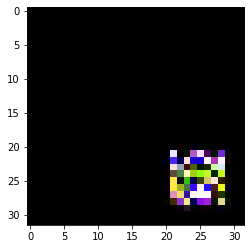

In [ ]:
# Check poison samples
plt.imshow(x_train[5])
plt.show()

In [ ]:
uploaded = files.upload() # upload a model.pt file from challenge dataset
uploaded = files.upload() # upload wrn.py file found in starter repo for challenge (https://github.com/mmazeika/tdc-starter-kit)

Saving model.pt to model.pt


Saving wrn.py to wrn.py


In [ ]:
import torch
import torchvision.models as models

model = torch.load("model.pt")
model.eval()

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, 

In [ ]:
import math
import random
import numpy as np
import time
import scipy
  
def superimpose(background, overlay):
  added_image = cv2.addWeighted(background,1,overlay,1,0)
  return (added_image.reshape(32,32,3))

def entropyCal(background, n):
  entropy_sum = [0] * n
  x1_add = [0] * n
  index_overlay = np.random.randint(40000,49999, size=n)
  for x in range(n):
    x1_add[x] = torch.tensor((superimpose(background, x_train[index_overlay[x]]))).permute(dims=[2, 0, 1]).unsqueeze(dim=0)

  py1_add = model(torch.cat(x1_add, dim=0))
  py1_add = py1_add.detach().numpy()
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
  return EntropySum

n_test = 300
n_sample = 10
entropy_benign = [0] * n_test
entropy_trojan = [0] * n_test
# x_poison = [0] * n_test

for j in range(n_test):
  if 0 == j%10:
    print(j)
  x_background = x_train[j+26000] 
  entropy_benign[j] = entropyCal(x_background, n_sample)

for j in range(n_test):
  if 0 == j%10:
    print(j)
  x_poison = poison(x_train[j+14000])
  entropy_trojan[j] = entropyCal(x_poison, n_sample)

entropy_benign = [x *.5 / n_sample for x in entropy_benign] # get entropy for 2000 clean inputs
entropy_trojan = [x * 0.05 / n_sample for x in entropy_trojan] # get entropy for 2000 trojaned inputs

0


<ipython-input-21-87a08e675d0f>:20: RuntimeWarning: invalid value encountered in log2
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


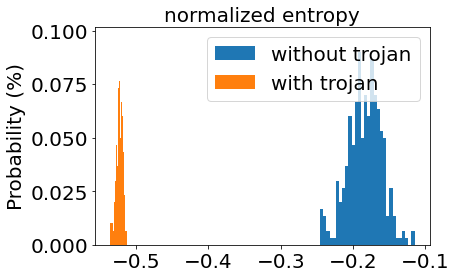

In [ ]:
bins = 30
plt.hist(entropy_benign, bins, weights=np.ones(len(entropy_benign)) / len(entropy_benign), alpha=1, label='without trojan')
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()

ValueError: ignored

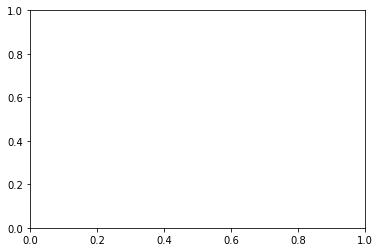

In [ ]:
# As trojaned entropy is sometimes too small to be visible. 
# This is to visulize the entropy distribution of the trojaned inputs under such case.
bins = np.linspace(0, max(entropy_trojan), 30)
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')


plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()

In [ ]:
import scipy
import scipy.stats

(mu, sigma) = scipy.stats.norm.fit(entropy_benign)
print(mu, sigma)

threshold = scipy.stats.norm.ppf(0.01, loc = mu, scale =  sigma) #use a preset FRR of 0.01. This can be 
print(threshold)

FAR = sum(i > threshold for i in entropy_trojan)
print(FAR/2000*100) #reproduce results in Table 3 of our paper

1.1454090723991392 0.0330496707863826
1.0685240410274883
0.0


In [ ]:
min_benign_entropy = min(entropy_benign)
max_trojan_entropy = max(entropy_trojan)

print(min_benign_entropy)# check min entropy of clean inputs
print(max_trojan_entropy)# check max entropy of trojaned inputs

0.9972339630126953
-3.197671890258789
